# 3. Evaluate behavior parameters



In this notebook, we will use the trained model to evaluate the dynamics behvior parameters: g, v, D for each cell. The combination of these three parameter shapes the dynamic behavior of a cell. We can archive taht by reading the experimental config file and easily:
- load the trained model
- load the data 
- evaluate the parameters
- perform short-term simulation 

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
if sys.platform.startswith("darwin"):
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
sc.settings.set_figure_params(frameon=False, dpi=30)

import pseudodynamics as pdp
os.chdir(pdp.main_dir)
print("workding directory changed to:", pdp.main_dir)

/rds/user/wz369/hpc-work/LIBS/mamba/envs/PINN_env/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/rds/user/wz369/hpc-work/LIBS/mamba/envs/PINN_env/lib/python3.9/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment

workding directory changed to: /rds/user/wz369/hpc-work/pseudodynamics_plus


# Experimental Config

In [2]:
tompos_config_path = "logs/tom_pos-DM_scaled_n[0, 1, 2, 3, 4, 6, 8]/pde_params_tsense/V4_config.json"
tompos_config = pdp.ExperimentConfig(config=tompos_config_path)

In [3]:
tompos_config.find_lastest_ckpt()

'logs/tom_pos-DM_scaled_n[0, 1, 2, 3, 4, 6, 8]/pde_params_tsense/lightning_logs/version_4/checkpoints/epoch=95-total_loss=1.33532071.ckpt'

In [4]:
from pseudodynamics import models
pde_model = models.pde_params.load_from_checkpoint(
                    checkpoint_path = tompos_config.find_lastest_ckpt(), 
                    map_location='cpu')

/rds/user/wz369/hpc-work/LIBS/mamba/envs/PINN_env/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.3.0, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(


Check whether it learns time-dependent parameters

In [5]:
pde_model.time_sensitive

True

# resume dataloder

We can retrieve which single cell dataset to use from basic experimental config

In [6]:
# load config
data_name = tompos_config.experiment_config['dataset']
print(data_name)

# load adata
adata = sc.read_h5ad(f"data/{data_name}.h5ad")
adata

tom_pos


AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

We can resume a DataSet object with the single-cell data and the settings. By default we use the TwoTiempoint_AnnDS which trains the model for connecting two consecutive time points.

In [10]:
# # To resume the original dataloader without masked-out time point
from pseudodynamics import reader
DS_sub = pdp.reader.TwoTimpepoint_AnnDS(AnnData=adata, split = 'train',
                                **tompos_config.dataset_config
                              )


Dataset : Computing density :
	 `density_funs` not specified, default estimator gaussian kde


In [11]:
# To resume the full dataset with all time points
ds_config = tompos_config.dataset_config.copy()
ds_config['timepoint_idx'] = None

DS_full = reader.TwoTimpepoint_AnnDS(AnnData=adata, split = None,
                            **ds_config
                        )                       


Dataset : Computing density :
	 `density_funs` not specified, default estimator gaussian kde
Dataset : all cells are used


# Predict dynamic parameters for single cell 

***pseudodynamics+*** follows a advected-diffusion equotion to model the density changes :

$$ \frac{\partial }{{\partial t}}u\left( { \mathbf{s},t} \right) = 
\underbrace{g\left( { \mathbf{s},t} \right)u\left( { \mathbf{s},t} \right)}_{\textrm{growth}}
- \underbrace{\nabla_{\mathbf{s}} \left( {v\left( { \mathbf{s},t} \right)u( \mathbf{s},t)} \right)}_{\textrm{drift}} 
+ \underbrace{\nabla_{\mathbf{s}} \left( {D\left( { \mathbf{s},t} \right)\nabla_{\mathbf{s}} u( \mathbf{s},t)} \right)}_{\textrm{diffusion}} 
$$

We takes all the captured single cell expression and its low-dimensional representation as the full cell state space. For time-dependent parameters, the growth rate ($g$), differentation rate ($v$) and Diffusion ($D$) can change by $t$ even for the same cell state $s$.

In [12]:
# here we have a one-line code to predict the parameters for all cell and time point
g_pred_ay, v_pred_ay, D_pred_ay = pde_model.predict_param(DS_full)


print(f'the number of cell : {adata.shape[0]}')
print(f'the number of time points : {adata.uns["pop"]["t"].shape[0]}' )
print('the shape of growth rate :\t\t', g_pred_ay.shape)
print('the shape of differentaition rate :\t', v_pred_ay.shape)
print('the shape of diffusion :\t\t', D_pred_ay.shape)

the number of cell : 49390
the number of time points : 9
the shape of growth rate :		 (9, 49390)
the shape of differentaition rate :	 (9, 49390, 10)
the shape of diffusion :		 (9, 49390)


prediction of shape (9, 49390)


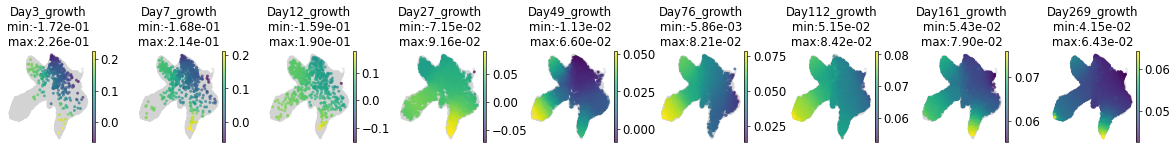

In [ ]:
# we can visualize the growth rate by 
fig, ax = pdp.pl.params_in_umap(adata, prediction=g_pred_ay, param = 'growth')

Differentiation rate is a high-dimensional vector which denotes the immediate movement in every dimension of the diffusion map space. To visualize it, we calculate the vectorial sum which represent the overall distance of movement in a short time interval.

prediction of shape (9, 49390)


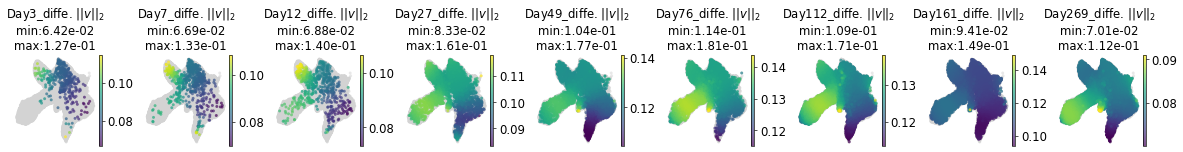

In [41]:
v_norm = np.sqrt(np.sum(v_pred_ay**2, axis=-1))
fig, ax = pdp.pl.params_in_umap(adata, prediction=v_norm, param = r'diffe. $||v||_2$')

For computational simplicity, *pseudodynamics+* assumes an isogenic diffusion parameter, which means $D$ is the same for all dimension. Parameter $D$ also buffers the under-fit density changes during training, which makes it diffcult to interpret.

## predicting parameters for arbitrary time point 

*pseudodynamics+* learns a behavior network corresponding to each parameter. This network allows us to impute the parameters for any time point.

In [13]:
import torch
# the cell state matrix
s = torch.from_numpy(DS_full.cellstate).float()
print(s.shape, s.dtype)

torch.Size([49390, 10]) torch.float32


In [14]:
# for example we impute day 5 and day 18
g_impute = []

with torch.no_grad():
    
    for t in [5,18,36]:
        t_input = torch.Tensor([t]).broadcast_to((s.shape[0],1))     # make them a tenso
        g_t = pde_model.g(s,t_input).cpu().numpy()
        g_impute.append(g_t)

    g_impute = np.stack(g_impute)
    print(g_impute.shape)

(3, 49390)


prediction of shape (3, 49390)


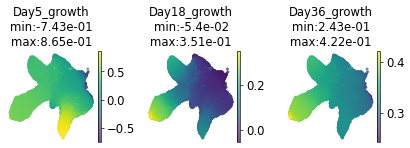

In [15]:
fig, ax = pdp.pl.params_in_umap(adata, prediction=g_impute, param = 'growth', timepoints=[5, 18, 36], cell_of_t=False)

## continuous parameters

Next we inspect the evolution of the parameters in a time-continuous way. For the ease of visualisation, we group the parameters by cell types.

In [ ]:
# 
grouped_params = pdp.tl.continuous_params(pde_model, DS_full, 
                                        param='g',
                                        groupby_key='fine_anno',  # group parameters by refined cell type, set to None if you want to keep single cell resolution
                                        n_interval=10,      # the resolution, the number of time intervals between two observed time points 
                                        device='cpu') 

grouped_param = pd.concat(grouped_params, axis=0)
grouped_param['g'] = grouped_param['g'].values 
grouped_param = grouped_param.query("`ct_of_day` > 10")   # only include cell type with more than 10 cells at the time
grouped_param['variable'] = grouped_param.variable.astype(float)

0it [00:00, ?it/s]

from 1.0 to 2.3333333333333335
from 2.3333333333333335 to 4.0
from 4.0 to 9.0
from 9.0 to 16.333333333333332
from 16.333333333333332 to 25.333333333333332
from 25.333333333333332 to 37.333333333333336
from 37.333333333333336 to 53.666666666666664
from 53.666666666666664 to 89.66666666666667


/tmp/ipykernel_2048953/1522600212.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  g.legend(frameon=False)


Text(0.5, 0, 'Time point (Day)')

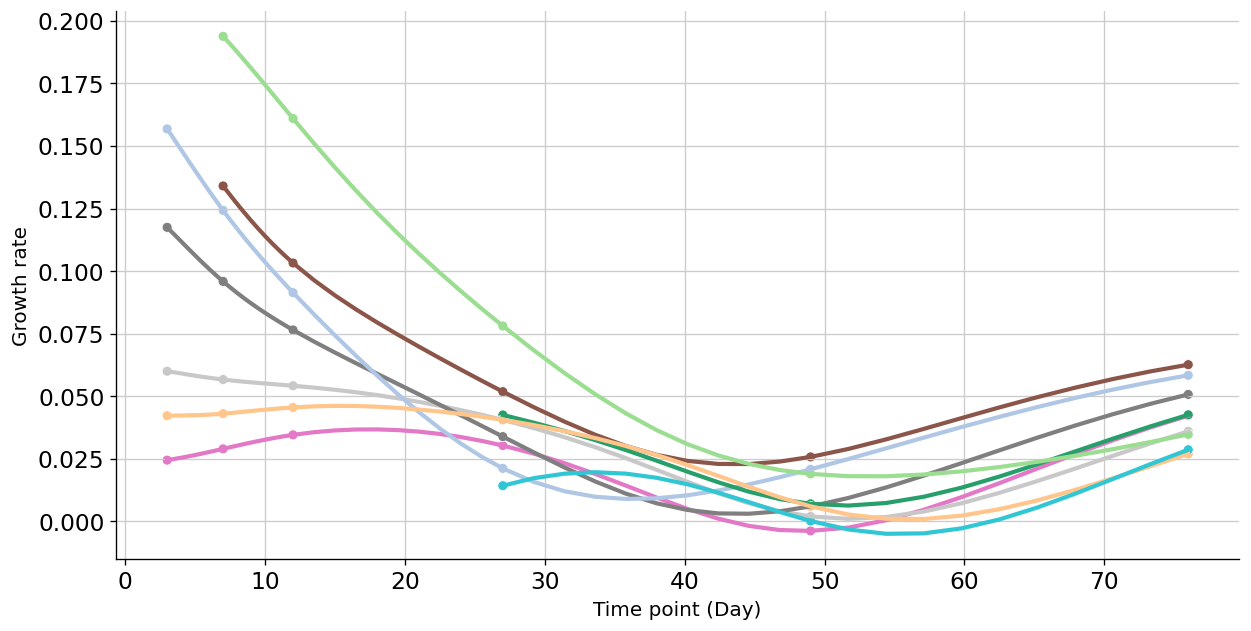

In [ ]:

import seaborn as sns

celltype_pallete = dict(zip(adata.obs['fine_anno'].cat.categories, adata.uns['fine_anno_colors']))

all_int_time = grouped_param['variable'].unique()
intermediate_time = all_int_time.astype(float)[np.arange(0,81,5)]
obs_T = all_int_time[np.arange(0,81,10)]

grouped_param_shorter = grouped_param.query('`variable` <= 76')

fig = plt.figure(dpi=60, figsize=(12,6), frameon=True)
fig.tight_layout(rect=[-0.5,-0.6,1.05,1])
ax = plt.gca()
g = sns.lineplot(data=grouped_param_shorter, x='variable', y='g', 
                 hue='fine_anno', palette=celltype_pallete,
                 ax=ax, linewidth=2.5,  legend=False,
                 )
sns.scatterplot(data=grouped_param_shorter.query('`variable` in @obs_T'), x='variable', y='g', 
                 hue='fine_anno', palette=celltype_pallete,
                 marker='o', legend=False,
                 ax=ax
                 )
g.legend(frameon=False)
sns.despine(ax=g)
g.set_ylabel("Growth rate", fontsize=12)
g.set_xlabel("Time point (Day)", fontsize=12)




## relative rate 

In [ ]:
ct_v = pdp.tl.agg_param(adata, param=v_norm, groupby_key='fine_anno')

# devided by HSC diff. rate at each time point
ct_v = ct_v / ct_v.loc['HSC'].values
ct_v = ct_v.iloc[1:]
ct_v

,3,7,12,27,49,76,112,161,269
fine_anno,,,,,,,,,
Int prog,0.951509,0.948143,0.946480,0.954658,0.971870,0.978862,0.976192,0.971520,0.983403
Meg/Ery prog,1.103668,1.080631,1.053332,1.007929,1.003839,1.012451,1.019313,1.017308,0.996447
Meg prog,1.257982,1.213439,1.154104,1.029407,0.996088,1.010542,1.030349,1.035039,0.986352
Ery prog,NaN,1.126284,1.101114,1.057837,1.045450,1.050072,1.056368,1.062031,1.067730
Bas/MC prog,NaN,NaN,NaN,1.030836,1.035418,1.030897,1.024646,1.025491,1.045519
Mono/DC prog,0.867872,0.870660,0.878811,0.915198,0.951611,0.963209,0.958827,0.953618,0.976415
Neu prog,NaN,1.127819,1.046997,0.888185,0.868440,0.903406,0.917731,0.907134,0.905516
Ly,NaN,NaN,NaN,1.013007,1.010506,1.003521,0.999422,1.002034,1.017815


Text(0.5, 32.777777777777786, 'timepoints')

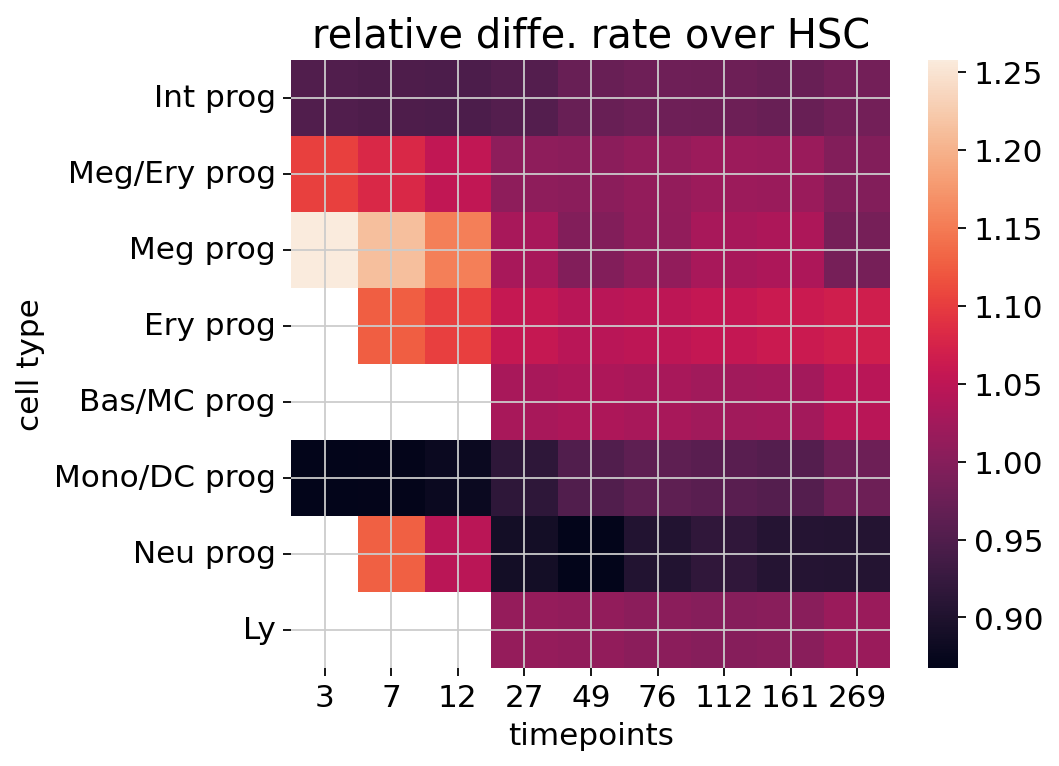

In [96]:
fig = plt.figure(figsize=(6, 5), dpi=80)
ax = fig.gca()
sns.heatmap(data=ct_v, ax=ax)
ax.set_title('relative diffe. rate over HSC', fontsize=18)
ax.set_ylabel('cell type')
ax.set_xlabel('timepoints')

# Simulating density change

The above equation describe the change of density over time. Now with the parameters and the suggorate model, we can formulate a simulation of the density change using NeuralODE.

Here when using TwoTimpepoint_AnnDS, we take the based density from the last time point to simualate the density at the next time point.

In [16]:
# a one line code for short term simulation( two consecutive time points) 
u_sim = pdp.tl.density_shortterm_simulation(pde_model, DataSet=DS_full, timepoints=adata.uns['pop']['t'])
u_int_all = np.concatenate([DS_full.u_b[0,None], u_sim], axis=0)

print(u_int_all.shape)

0it [00:00, ?it/s]

simulating from timepoint 3 to 7


simulating from timepoint 7 to 12
simulating from timepoint 12 to 27
simulating from timepoint 27 to 49
simulating from timepoint 49 to 76
simulating from timepoint 76 to 112
simulating from timepoint 112 to 161
simulating from timepoint 161 to 269
(9, 49390)


In [ ]:
# unseen time points
seen_i = tompos_config.dataset_config['timepoint_idx']
masked_i = [i for i,t in enumerate(adata.uns['pop']['t']) if i not in seen_i]

masked_t = adata.uns['pop']['t'][masked_i]
seen_t = adata.uns['pop']['t'][seen_i]

print("seen time points : ", seen_t)
print("held-out time points : ", masked_t)


seen time points :  [  3   7  12  27  49 112 269]
held-out time points :  [ 76 161]


The model predict pretty well in terms of the density

prediction of shape (2, 49390)


prediction of shape (2, 49390)


(<Figure size 162x60 with 4 Axes>,
 array([<Axes: title={'center': 'Day76_$\\log{u_{sim}}$\nmin:-1.15e+01\nmax:-6.26e+00'}, xlabel='UMAP1', ylabel='UMAP2'>,
        <Axes: title={'center': 'Day161_$\\log{u_{sim}}$\nmin:-1.15e+01\nmax:-4.37e+00'}, xlabel='UMAP1', ylabel='UMAP2'>],
       dtype=object))

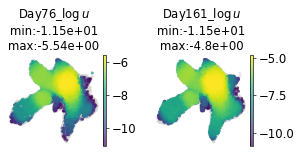

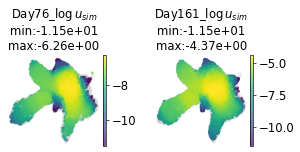

In [ ]:
# visualize the density at unseen time point during training and compare to ground turth
pdp.pl.params_in_umap(adata, np.log(DS_full.u_b[masked_i]+1e-5), timepoints=masked_t, param=r'$\log u$');
pdp.pl.params_in_umap(adata, np.log(u_int_all[masked_i]+1e-5), timepoints=masked_t, param=r'$\log{u_{sim}}$');

prediction of shape (7, 49390)


prediction of shape (7, 49390)


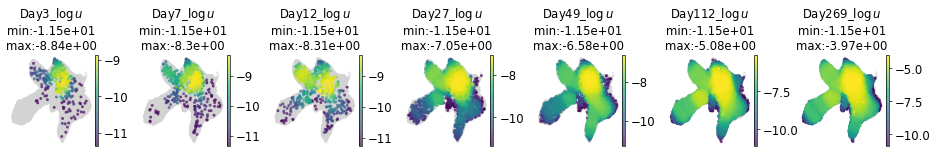

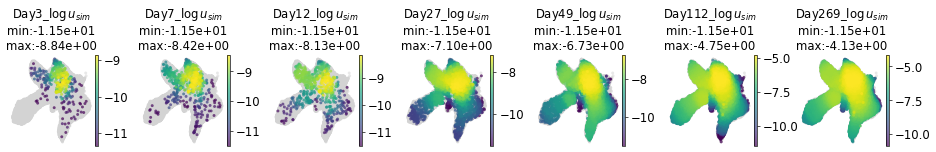

In [42]:
# let's check the seen time points
pdp.pl.params_in_umap(adata, np.log(DS_full.u_b[seen_i]+1e-5), timepoints=seen_t, param=r'$\log u$');
pdp.pl.params_in_umap(adata, np.log(u_int_all[seen_i]+1e-5), timepoints=seen_t, param=r'$\log{u_{sim}}$');

# What's Next
Link single-cell dynamics behavior with molecualr evidence:
- cell cycle phase  (growth rate $g$)
- differentiation rate association test (diffe. rate $v$)